Fetch commit history from tmux GitHub repo


In [55]:
import pandas as pd
import csv
import requests
from datetime import datetime, timedelta
import re
import matplotlib.pyplot as plt
import seaborn as sns
owner = "tmux"
repo = "tmux"
branch = "master"
days = 1826  # 5 years
since = (datetime.now() - timedelta(days=days)).isoformat()

In [ ]:
base_url = f"https://api.github.com/repos/{owner}/{repo}/commits"
params = {"sha": "master", "since": since, "per_page": 100}


def fetch_commit_history(url, params):
    commit_history = []
    while url:
        response = requests.get(url, params=params)
        if response.status_code == 200:
            commits = response.json()
            for commit in commits:
                commit_hash = commit['sha']
                author_name = commit['commit']['author']['name']
                commit_date = commit['commit']['author']['date']
                commit_message = commit['commit']['message']
                commit_url = commit['html_url']
                commit_history.append(
                    {
                        "date": commit_date,
                        "hash": commit_hash,
                        "message": commit_message,
                        "author_name": author_name,
                        "url": commit_url,
                    }
                )
            # Pagination
            if "next" in response.links:
                url = response.links["next"]["url"]
                params = {}  # Clear params since URL will contain them
            else:
                url = None
        else:
            print("Failed to fetch commits. Status Code:", response.status_code)
            break
    return commit_history


print(
    f"fetching commits since {since} from {owner}/{repo} on branch {branch}...")
commit_history = fetch_commit_history(base_url, params)
print(f"successfully fetched {len(commit_history)} commits")

with open("commit_history.csv", mode="w", newline="", encoding="utf-8") as file:
    writer = csv.DictWriter(
        file,
        fieldnames=[
            "date",
            "hash",
            "message",
            "author_name",
            "url",
        ],
    )
    writer.writeheader()
    writer.writerows(commit_history)

print(
    f"Successfully written {len(commit_history)} commits to commit_history.csv"
)

Fetch release history from GitHub repo


In [18]:
url = f"https://api.github.com/repos/{owner}/{repo}/releases"

# Fetch all releases
releases = []
while url:
    response = requests.get(url)
    if response.status_code == 200:
        releases.extend(response.json())
        url = response.links.get("next", {}).get("url", None)
    else:
        print(f"Failed to fetch releases: {response.status_code}")
        break

# Write to CSV
with open("release_history.csv", "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["Release Name", "Tag Name", "Created At", "Published At"])
    for release in releases:
        writer.writerow(
            [
                release["name"],
                release["tag_name"],
                release["created_at"],
                release["published_at"],
            ]
        )

print(f"Successfully written {len(releases)} releases to release_history.csv")

Successfully written 35 releases to release_history.csv


Fetch issues from GitHub repo


In [43]:
params = {"state": "closed", "since": {since}, "per_page": 100}

issues_history = []

url = f"https://api.github.com/repos/{owner}/{repo}/issues"

while url:
    response = requests.get(url, params=params)
    if response.status_code == 200:
        issues = response.json()
        for issue in issues:
            if "number" in issue and "closed_at" in issue:
                issues_history .append(
                    {"Issue Number": issue["number"], "Closed At": issue["closed_at"]}
                )
        url = response.links["next"]["url"] if "next" in response.links else None
    else:
        print("Failed to fetch issues. Status Code:", response.status_code)
        break

with open("issue_history.csv", "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["Issue Number", "Closed At"])
    for issue in issues_history :
        writer.writerow([issue["Issue Number"], issue["Closed At"]])
        
print(f"Successfully written {len(issues_history )} issues to issue_history.csv")

Successfully written 3786 issues to issue_history.csv


Process commit history to match with issues

In [49]:
commit_history = pd.read_csv('commit_history.csv')
issues_history = pd.read_csv('issue_history.csv')


def extract_issue_number(message):
    pattern = r"GitHub issue (\d+)"
    match = re.search(pattern, message)
    return int(match.group(1)) if match else None


commit_history['Linked Issue'] = commit_history['message'].apply(extract_issue_number)
commit_history = commit_history.merge(issues_history, left_on='Linked Issue', right_on='Issue Number', how='inner')
commit_history.loc[commit_history['Closed At'].notnull(), 'date'] = commit_history['Closed At']
commit_history['Is Linked to Issue'] = commit_history['Linked Issue'].notnull()

# Save the updated commit history
commit_history.to_csv('commit_history_linked_with_issues.csv', index=False)
print("Successfully written commit_history_linked_with_issues.csv")


Successfully written commit_history_linked_with_issues.csv


Compute time from release-ready to actual release: manual vs CD


In [53]:
def find_next_release(commit_date, release_dates):
    future_releases = release_dates[release_dates > commit_date]
    if not future_releases.empty:
        return future_releases.iloc[0]
    return None

def find_next_merge(commit_date, merge_dates):
    future_merges = merge_dates[merge_dates > commit_date]
    if not future_merges.empty:
        return future_merges.iloc[0]
    return None

release_history = pd.read_csv("release_history.csv")
release_history["Published At"] = pd.to_datetime(
    release_history["Published At"])
release_history = release_history.sort_values(by="Published At")

commit_history = pd.read_csv('commit_history_linked_with_issues.csv')
commit_history["date"] = pd.to_datetime(commit_history["date"])

# Identifying merge commits
merge_commits = commit_history[
    commit_history["message"].str.contains(
        "Merge branch 'obsd-master'", case=False, na=False
    )
]
merge_commits = merge_commits.sort_values(by="date")

commit_history = commit_history[commit_history["Is Linked to Issue"] == True]
commit_history["Closed At"] = pd.to_datetime(commit_history["Closed At"])
commit_history = commit_history.sort_values(by="Closed At")
commit_history["Next Release Time"] = commit_history["Closed At"].apply(
    lambda x: find_next_release(x, release_history["Published At"])
)
commit_history["Time to Next Release (Days)"] = (
    commit_history["Next Release Time"] - commit_history["Closed At"]
).dt.total_seconds() / (60 * 60 * 24)
commit_history["Next Merge Time"] = commit_history["Closed At"].apply(
    lambda x: find_next_merge(x, merge_commits["date"])
)
commit_history["Time to Next Merge (Days)"] = (
    commit_history["Next Merge Time"] - commit_history["Closed At"]
).dt.total_seconds() / (60 * 60 * 24)

commit_history = commit_history[
    (commit_history["Time to Next Release (Days)"].notnull())
    & (commit_history["Time to Next Merge (Days)"].notnull())
]

commit_history.to_csv("processed_commit_history.csv", index=False)
print("Successfully written processed_commit_history.csv")

Successfully written processed_commit_history.csv


Analysis

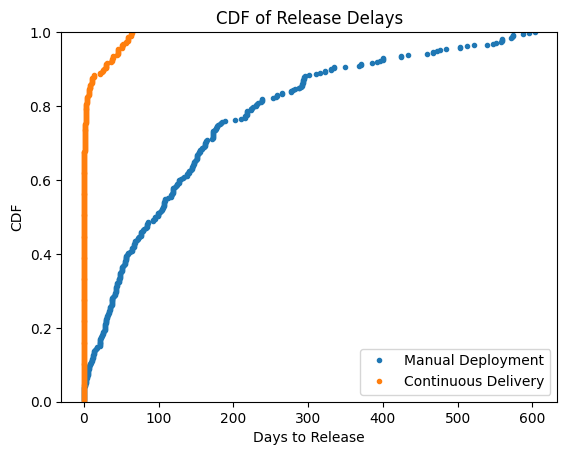

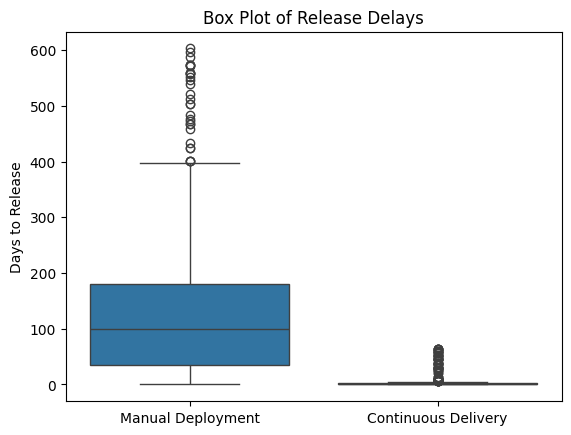

In [60]:
df = pd.read_csv("processed_commit_history.csv")

# Renaming columns for clarity
df.rename(
    columns={
        "Time to Next Release (Days)": "Manual Release Delay (Days)",
        "Time to Next Merge (Days)":  "CD Release Delay (Days)",
    },
    inplace=True,
)

# Plot CDF for Manual and CD release delays
plt.figure()
sns.ecdfplot(data=df, x="Manual Release Delay (Days)", label='Manual Deployment', marker='.', linestyle='none')
sns.ecdfplot(data=df, x="CD Release Delay (Days)", label='Continuous Delivery', marker='.', linestyle='none')
plt.title('CDF of Release Delays')
plt.xlabel('Days to Release')
plt.ylabel('CDF')
plt.legend()
plt.savefig('cdf_plot.png', bbox_inches='tight', dpi=300)

# Plot Box plot for Manual and CD release delays
plt.figure()
sns.boxplot(data=df[['Manual Release Delay (Days)', 'CD Release Delay (Days)']])
plt.title('Box Plot of Release Delays')
plt.ylabel('Days to Release')
plt.xticks([0, 1], ['Manual Deployment', 'Continuous Delivery'])
plt.savefig('box_plot.png', bbox_inches='tight', dpi=300)

plt.show()